<a href="https://colab.research.google.com/github/Shuwen-Fang/Inference-Quickstart/blob/main/%5BEXTERNAL%5D%20Inference%20Quickstart%20Colab%20Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore Benchmarking Data with Inference Quickstart
This notebook is a hands-on guide to the Google Inference Quickstart (GIQ) recommender API. It's designed to help you explore performance and pricing metrics for serving open-source Large Language Models (LLMs) on Google Kubernetes Engine (GKE).

By the end of this guide, you'll be able to compare the price and performance of serving LLMs with different accelerators on GKE, understand the critical trade-offs between latency, throughput, and cost, and select the optimal hardware configuration to meet your specific performance goals and budget.


## Authenticate and Initialize Environment


In [1]:
project_id = "" # @param {type:"string"}

if not project_id:
  raise ValueError("Please enter your Project ID in the 'project_id' variable.")

# Import all libraries
from IPython.display import Image, display
import uuid
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns

# Initialize shared functions
def convert_to_decimal_cost(cost_dict):
  """Converts cost from a dictionary with 'units' and 'nanos' to a decimal representation."""
  units = int(cost_dict.get("units", 0))
  nanos = int(cost_dict.get("nanos", 0))
  return units + nanos / 1e9



In [ ]:
# Use the outputted link to authenticate your gcloud access
!gcloud auth login
!gcloud config set project {project_id}
!gcloud services enable gkerecommender.googleapis.com --project {project_id}

## Explore supported configurations
Before diving into a specific model, let's get a high-level view of the model supported by GIQ and how they compare in terms of intelligence and cost.

In [3]:
supported_models_json = !curl "https://gkerecommender.googleapis.com/v1/models:fetch" \
  -H "Content-Type: application/json" \
  -H "X-Goog-User-Project: {project_id}" \
  -H "User-Agent: curl/7.92.0 google-colab" \
  -H "X-Goog-Api-Client: curl/7.92.0 google-colab" \
  -H "Authorization: Bearer $(gcloud auth print-access-token)"\
  -A "google-colab"

supported_models_str = "".join(supported_models_json)
supported_models_data = json.loads(supported_models_str)
print("Supported Models:")
for model in supported_models_data["models"]:
  print(f"- {model}")

Supported Models:
- Qwen/Qwen3-32B
- deepseek-ai/DeepSeek-R1
- deepseek-ai/DeepSeek-R1-Distill-Qwen-7B
- google/gemma-2-27b-it
- google/gemma-2-2b-it
- google/gemma-3-27b-it
- google/gemma-3-4b-it
- meta-llama/Llama-3.2-1B-Instruct
- meta-llama/Llama-3.3-70B-Instruct
- meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8
- meta-llama/Llama-4-Scout-17B-16E-Instruct
- meta-llama/Meta-Llama-3-8B
- mistralai/Mistral-Small-24B-Instruct-2501
- mistralai/Mixtral-8x22B-Instruct-v0.1
- mistralai/Mixtral-8x7B-Instruct-v0.1
- openai/gpt-oss-120b
- openai/gpt-oss-20b


### Compare Model Intelligence and Cost
Model elo ratings are retrieved from the Chatbot Arena as of July 2025. This analysis focuses on models supported by both Google Inference Quickstart (GIQ) and Chatbot Arena for a comparative view of intelligence and cost.

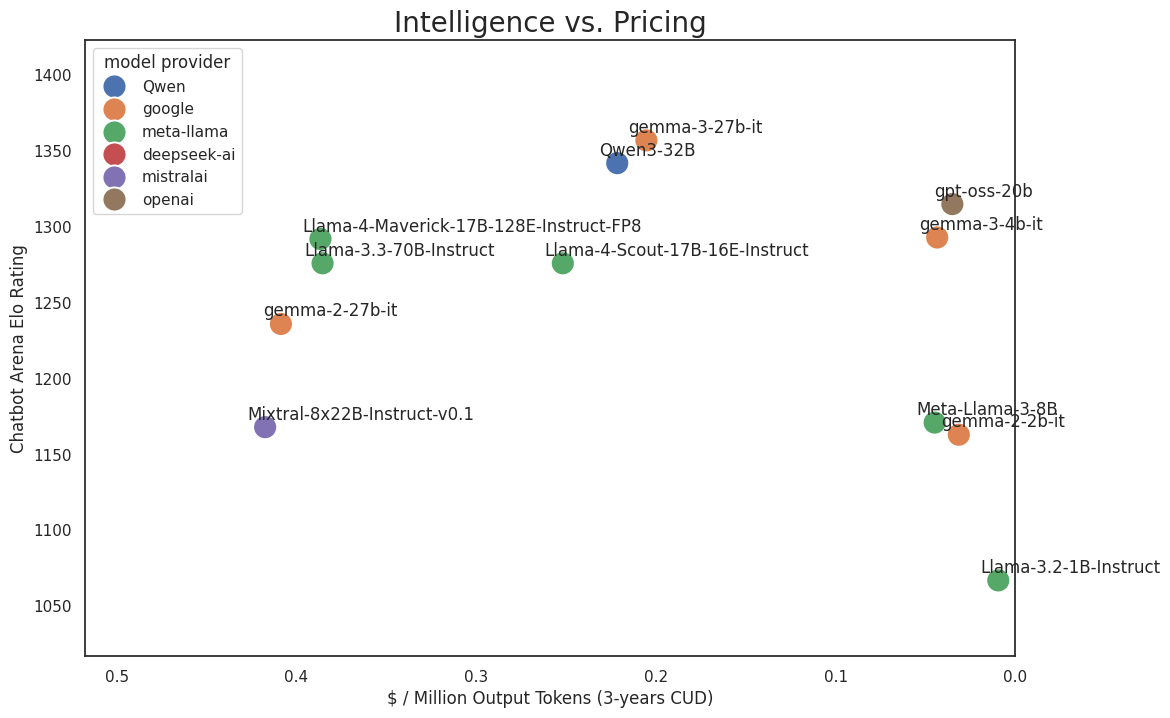

In [4]:
pricing_model = "spot" # @param ["3-years-cud", "1-year-cud", "on-demand", "spot"]
# Retrieved as of 08/20/2025
model_elo_data = [
    {
        "model_name": "Qwen/Qwen3-32B",
        "elo_rating": 1342,
    },
    {
        "model_name": "google/gemma-2-27b-it",
        "elo_rating": 1236,
    },
    {
        "model_name": "google/gemma-2-2b-it",
        "elo_rating": 1163,
    },
    {
        "model_name": "google/gemma-3-27b-it",
        "elo_rating": 1357,
    },
    {
        "model_name":"google/gemma-3-4b-it",
        "elo_rating":1293,
    },
    {
        "model_name": "meta-llama/Llama-3.2-1B-Instruct",
        "elo_rating": 1067,
    },
    {
        "model_name": "meta-llama/Llama-3.3-70B-Instruct",
        "elo_rating": 1276,
    },
    {
        "model_name": "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
        "elo_rating": 1292,
    },
    {
        "model_name":"meta-llama/Llama-4-Scout-17B-16E-Instruct",
        "elo_rating":1276,
    },
    {
        "model_name": "meta-llama/Meta-Llama-3-8B",
        "elo_rating": 1171,
    },
    {
        "model_name":"deepseek-ai/DeepSeek-R1",
        "elo_rating":1373,
    },
    {
        "model_name":"mistralai/Mixtral-8x22B-Instruct-v0.1",
        "elo_rating":1168,
    },
    {
        "model_name":"mistralai/Mixtral-8x7B-Instruct-v0.1",
        "elo_rating":1138,
    },
    {
        "model_name":"openai/gpt-oss-120b",
        "elo_rating": 1368,
    },
    {
        "model_name":"openai/gpt-oss-20b",
        "elo_rating":1315,
    }
]

model_elo_dict = {item["model_name"]: item for item in model_elo_data}

model_server_info_json = json.dumps({})
profiles_json = !curl "https://gkerecommender.googleapis.com/v1/profiles:fetch" \
  -H "Content-Type: application/json" \
  -H "X-Goog-User-Project: {project_id}" \
  -H "User-Agent: curl/7.92.0 google-colab" \
  -H "X-Goog-Api-Client: curl/7.92.0 google-colab" \
  -H "Authorization: Bearer $(gcloud auth print-access-token)" \
  -d '{model_server_info_json}'
profiles_str = "".join(profiles_json)
profiles = json.loads(profiles_str)

for profile in profiles["profile"]:
    model_name = profile["modelServerInfo"]["model"]
    if model_name in model_elo_dict:
        for stats in profile["performanceStats"]:
            if "cost" in stats and stats["cost"]:
                cost_info = stats["cost"][0]
                model_elo_dict[model_name]["output_token_cost_per_million"] = convert_to_decimal_cost(cost_info["costPerMillionOutputTokens"])
                # You might want to add input token cost as well if needed
                # model_elo_dict[model_name]["input_token_cost_per_million"] = convert_to_decimal_cost(cost_info["costPerMillionInputTokens"])

model_elo_cost_data = list(model_elo_dict.values())

sns.set_theme(style="white")

elo_cost_df = pd.DataFrame(model_elo_cost_data)

elo_cost_df['model provider'] = elo_cost_df['model_name'].apply(lambda x: x.split('/')[0])

plt.figure(figsize=(12, 8))
ax = sns.scatterplot(data=elo_cost_df, x='output_token_cost_per_million', y='elo_rating', hue='model provider', s=300)

for i, txt in enumerate(elo_cost_df['model_name']):
    label = txt.split('/')[-1]
    plt.annotate(label, (elo_cost_df['output_token_cost_per_million'][i] + 0.01, elo_cost_df['elo_rating'][i] + 5))

plt.ylabel("Chatbot Arena Elo Rating")
plt.xlabel("$ / Million Output Tokens (3-years CUD)")
plt.title("Intelligence vs. Pricing", fontsize=20)

plt.xlim(elo_cost_df['output_token_cost_per_million'].max() + 0.1, 0)
plt.ylim(elo_cost_df['elo_rating'].min() - 50, elo_cost_df['elo_rating'].max() + 50)
plt.show()

### Analyze a Specific Model
In the following steps, we will:
1.  Select a model and model server to analyze.
2.  Optionally select a model server version. If not specified, this defaults to the latest model server version.
3.  Visualize the trade-offs between throughput, latency, and cost across different hardware configurations.

In [5]:
# This is required
model = "google/gemma-2-27b-it" # @param {type:"string"}

In [6]:
model_servers_json = !curl "https://gkerecommender.googleapis.com/v1/modelServers:fetch?model={model}" \
  -H "Content-Type: application/json" \
  -H "X-Goog-User-Project: {project_id}" \
  -H "User-Agent: curl/7.92.0 google-colab" \
  -H "X-Goog-Api-Client: curl/7.92.0 google-colab" \
  -H "Authorization: Bearer $(gcloud auth print-access-token)"\
  -A "colab-guide/1.0"


model_servers_str = "".join(model_servers_json)
model_servers_data = json.loads(model_servers_str)

print("Supported model servers:")
for model_server in model_servers_data["modelServers"]:
  print("-", model_server)

Supported model servers:
- vllm


In [7]:
model_server = "vllm" # @param {type:"string"}

In [8]:
model_server_versions_json = !curl "https://gkerecommender.googleapis.com/v1/modelServerVersions:fetch?model={model}&modelServer={model_server}" \
  -H "Content-Type: application/json" \
  -H "X-Goog-User-Project: {project_id}" \
  -H "User-Agent: curl/7.92.0 google-colab" \
  -H "X-Goog-Api-Client: curl/7.92.0 google-colab" \
  -H "Authorization: Bearer $(gcloud auth print-access-token)"\
  -A "colab-guide/1.0"

model_server_versions_str = "".join(model_server_versions_json)

model_server_versions_data = json.loads(model_server_versions_str)
print("Supported model server versions:")
for model_server_version in model_server_versions_data["modelServerVersions"]:
  print("-", model_server_version)

Supported model server versions:
- v0.7.2


In [9]:
# Optional, defaults to latest model server version
model_server_version = "" # @param {type:"string"}

## Visualizing Performance and Cost tradeoffs
We will create a series of visualizations from the benchmarking data we fetched. These charts are designed to help you answer the most critical questions about serving performance.

### Preparing The Data

#### Select Pricing Model and Performance Goals
We recommend defaulting to None in the first pass to understand the performance range that can be achieved for your given model, and then specifying performance requirements to get a more detailed understanding of how they fit your requirements.

In [10]:
pricing_model = "spot" # @param ["3-years-cud", "1-year-cud", "on-demand", "spot"]
max_ntpot = None # @param
max_ttft = None # @param
max_cost_per_million_output_tokens = None # @param
max_cost_per_million_input_tokens = None # @param

### Fetching data from the API

In [11]:
# Retrieve benchmarking data
model_server_info_payload = {
    "model_server_info": {
        "model": model,
        "modelServer": model_server,
        "modelServerVersion": model_server_version
    }
}
model_server_info_json = json.dumps(model_server_info_payload)

benchmarking_data_json = !curl "https://gkerecommender.googleapis.com/v1/benchmarkingData:fetch" \
  -H "Content-Type: application/json" \
  -H "X-Goog-User-Project: {project_id}" \
  -H "User-Agent: curl/7.92.0 google-colab" \
  -H "X-Goog-Api-Client: curl/7.92.0 google-colab" \
  -H "Authorization: Bearer $(gcloud auth print-access-token)" \
  -d '{model_server_info_json}'\
  -A "colab-guide/1.0"

benchmarking_data_str = "".join(benchmarking_data_json)

benchmarking_data = json.loads(benchmarking_data_str)

# Retrieving performance metrics at the highest price/perf point given performance goals
cost_requirements = {
    "pricing_model": pricing_model
}
if max_cost_per_million_output_tokens is not None:
  cost_requirements["cost_per_million_output_tokens"] = {"nanos": int(max_cost_per_million_output_tokens * 1e9)}
if max_cost_per_million_input_tokens is not None:
  cost_requirements["cost_per_million_input_tokens"] = {"nanos": int(max_cost_per_million_input_tokens * 1e9)}

profiles_payload = {
    "model": model,
    "model_server": model_server,
    "model_server_version": model_server_version,
    "performance_requirements": {
        "target_ntpot_milliseconds": max_ntpot,
        "target_ttft_milliseconds": max_ttft,
        "target_cost": cost_requirements,
    }
}

model_server_info_json = json.dumps(profiles_payload)
profiles_json = !curl "https://gkerecommender.googleapis.com/v1/profiles:fetch" \
  -H "Content-Type: application/json" \
  -H "X-Goog-User-Project: {project_id}" \
  -H "User-Agent: curl/7.92.0 google-colab" \
  -H "X-Goog-Api-Client: curl/7.92.0 google-colab" \
  -H "Authorization: Bearer $(gcloud auth print-access-token)" \
  -d '{model_server_info_json}'\
  -A "colab-guide/1.0"

profiles_str = "".join(profiles_json)

profiles = json.loads(profiles_str)

flat_data = []

for profile in benchmarking_data["profile"]:
    instance_type = profile["instanceType"]
    accelerator_type = profile["acceleratorType"]
    model_name = profile["modelServerInfo"]["model"]
    model_server_name = profile["modelServerInfo"]["modelServer"]
    model_server_version = profile["modelServerInfo"]["modelServerVersion"]


    for stats in profile["performanceStats"]:
        row = {
            "model_name": model_name,
            "accelerator_type": accelerator_type,
            "instance_type": instance_type,
            "queries_per_second": stats["queriesPerSecond"],
            "output_tokens_per_second": stats["outputTokensPerSecond"],
            "ntpot_milliseconds": stats["ntpotMilliseconds"],
            "ttft_milliseconds": stats.get("ttftMilliseconds", None)
        }

        if "cost" in stats and stats["cost"]:
            cost_info = stats["cost"][0]
            row["pricing_model"] = cost_info["pricingModel"]
            row["cost_per_million_output_tokens_decimal"] = convert_to_decimal_cost(cost_info["costPerMillionOutputTokens"])
            row["cost_per_million_input_tokens_decimal"] = convert_to_decimal_cost(cost_info["costPerMillionInputTokens"])

        flat_data.append(row)

df = pd.DataFrame(flat_data)

### Visualizations

This first chart visualizes the fundamental trade-off in serving LLMs: **Throughput vs. Latency**.

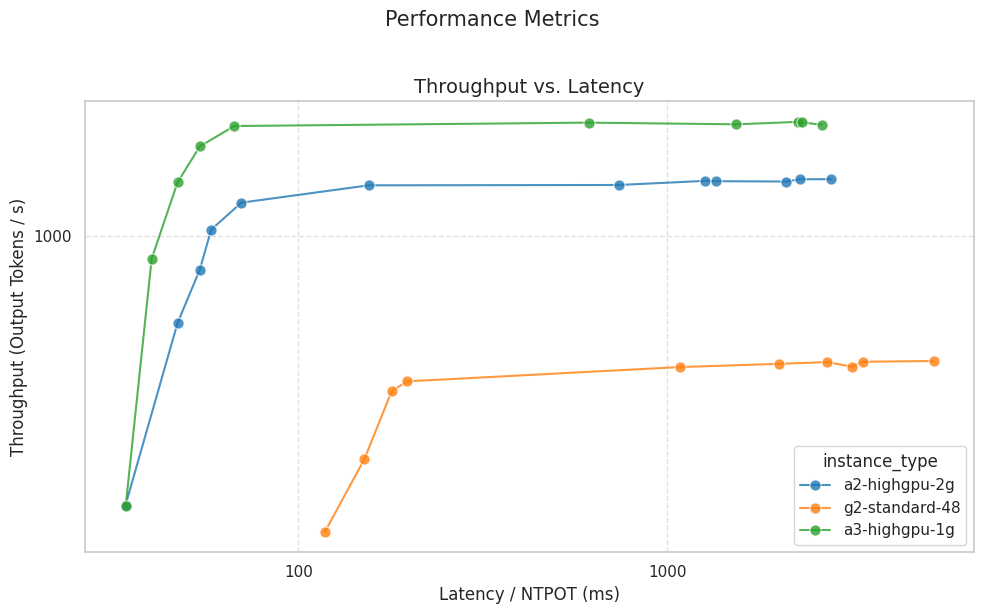

In [12]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle(f"Performance Metrics", fontsize=15, y=1.02)

# Plot the first graph (Throughput vs. NTPOT) in the left subplot
sns.lineplot(
    data=df,
    x="ntpot_milliseconds",
    y="output_tokens_per_second",
    hue="instance_type",
    marker='o',
    alpha=0.8,
    palette="tab10",
    markersize=8,
    ax=ax
)
ax.set_title("Throughput vs. Latency", fontsize=14)
ax.set_xlabel("Latency / NTPOT (ms)")
ax.set_ylabel("Throughput (Output Tokens / s)")
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())


handles, labels = ax.get_legend_handles_labels()

plt.tight_layout()

plt.show()

You can get the throughput, latency and cost data for benchmarking profiles that meet your performance requirements as a table:

In [13]:
def get_key_metrics(data, model_name_filter):
    """Extracts key metrics from the profile data and returns a DataFrame."""

    flat_data = []
    for profile in data["profile"]:
        if profile["modelServerInfo"]["model"] != model_name_filter:
            continue

        instance_type = profile["instanceType"]
        accelerator_type = profile["acceleratorType"]
        model_name = profile["modelServerInfo"]["model"]
        model_server_name = profile["modelServerInfo"]["modelServer"]
        model_server_version = profile["modelServerInfo"]["modelServerVersion"]

        for stats in profile["performanceStats"]:
            row = {
                "Instance Type": instance_type,
                "Accelerator Type": accelerator_type,
                "Throughput": stats["outputTokensPerSecond"],
                "Model Server": model_server_name,
                "Model Server Version": model_server_version[:10],
                "TPOT": stats["ntpotMilliseconds"],
            }

            if "cost" in stats and stats["cost"]:
                cost_info = stats["cost"][0]
                row["$/Input Token"] = round(convert_to_decimal_cost(cost_info.get("costPerMillionInputTokens", {})), 3)
                row["$/Output Token"] = round(convert_to_decimal_cost(cost_info.get("costPerMillionOutputTokens", {})), 3)
            else:
                row["$/Input Token"] = "N/A"
                row["$/Output Token"] = "N/A"

            flat_data.append(row)

    return pd.DataFrame(flat_data)
key_metrics_df = get_key_metrics(profiles, model)
key_metrics_df = key_metrics_df.sort_values(by="Instance Type")
display(key_metrics_df)

Instance Type   Accelerator Type  Throughput Model Server  \
1   a2-highgpu-2g  nvidia-tesla-a100        1243         vllm   
0   a3-highgpu-1g   nvidia-h100-80gb        2050         vllm   
2  g2-standard-48          nvidia-l4         425         vllm   

  Model Server Version  TPOT $/Input Token $/Output Token  
1               v0.7.2    70           N/A            N/A  
0               v0.7.2    67         0.055          0.222  
2               v0.7.2  1085         0.102          0.409

Performance is only half the story. Now let's compare the input and output token cost on different accelerators.


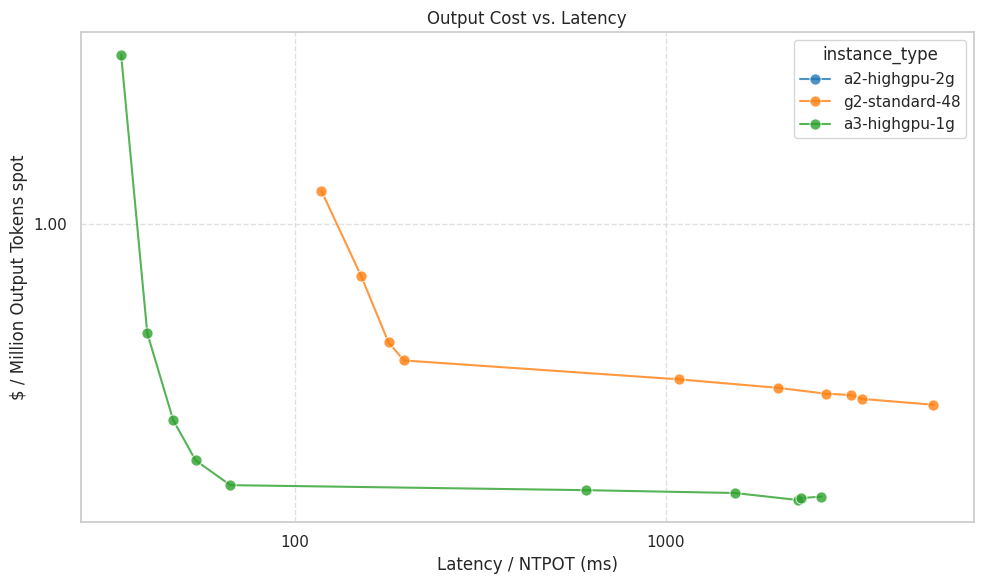

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.lineplot(
    data=df,
    x="ntpot_milliseconds",
    y="cost_per_million_output_tokens_decimal", # set this to cost_per_million_input_tokens_decimal to see input cost tradeoffs
    hue="instance_type",
    marker='o',
    alpha=0.8,
    palette="tab10",
    markersize=8,
    ax=axes
)
axes.set_title("Output Cost vs. Latency")
axes.set_xlabel("Latency / NTPOT (ms)")
axes.set_ylabel(f"$ / Million Output Tokens {pricing_model}")
axes.set_xscale('log')
axes.set_yscale('log')
axes.grid(True, linestyle='--', alpha=0.6)
axes.xaxis.set_major_formatter(mticker.ScalarFormatter())
axes.yaxis.set_major_formatter(mticker.ScalarFormatter())

plt.tight_layout()
plt.show()

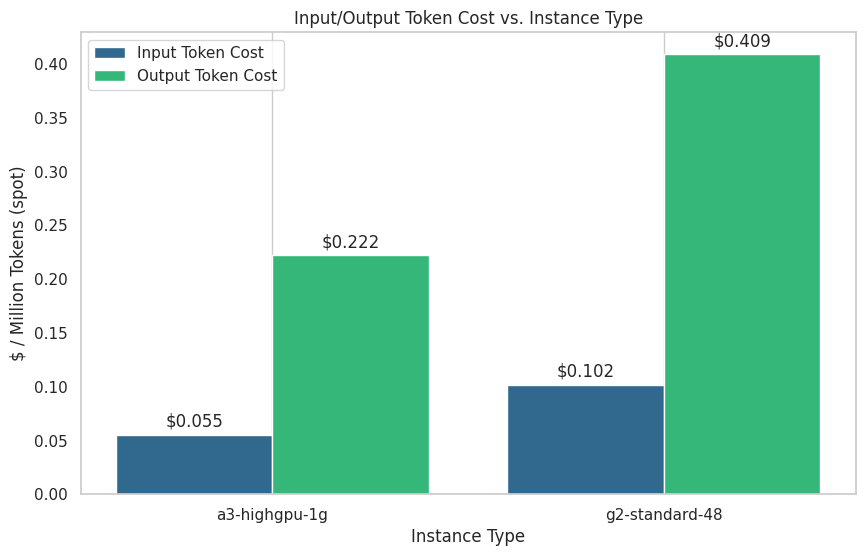

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = sns.color_palette("viridis", 2)

filtered_key_metrics_df = key_metrics_df[
    (key_metrics_df["$/Input Token"] != "N/A") &
    (key_metrics_df["$/Output Token"] != "N/A")
].copy()

x = np.arange(len(filtered_key_metrics_df["Instance Type"]))
ax.set_xticks(x)
ax.set_xticklabels(filtered_key_metrics_df["Instance Type"], rotation=0, ha="center")

rects1 = ax.bar(x - 0.2, filtered_key_metrics_df["$/Input Token"], width=0.4, label='Input Token Cost', color=colors[0])
rects2 = ax.bar(x + 0.2, filtered_key_metrics_df["$/Output Token"], width=0.4, label='Output Token Cost', color=colors[1])

ax.bar_label(rects1, padding=3, fmt='$%.3f')
ax.bar_label(rects2, padding=3, fmt='$%.3f')

ax.set_xlabel("Instance Type")
ax.set_ylabel(f"$ / Million Tokens ({pricing_model})")
ax.set_title("Input/Output Token Cost vs. Instance Type")
ax.grid(axis='y')

ax.legend()

plt.show()

## Beyond This Notebook
You've successfully used the GIQ Recommender API to explore performance and cost across hardware configurations on GKE! You can build your own plots to explore other dimensions of performance using our API.

Moving from analysis to production, GIQ can also generate a ready-to-deploy kubernetes manifest that allows you serve the model on your cluster with the exact configuration you've chosen.

For more details, check out our [official user guide](https://cloud.google.com/kubernetes-engine/docs/how-to/machine-learning/inference/inference-quickstart).

